In [1]:
import pandas as pd
import janitor
import datetime

from IPython.core.display import display, HTML
from pyvis import network as net
import networkx as nx

In [2]:
df_original = pd.read_csv("C:/Users/Genius7/Data_Science/Connections.csv", skiprows=2)

In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     430 non-null    object
 1   Last Name      430 non-null    object
 2   Email Address  10 non-null     object
 3   Company        415 non-null    object
 4   Position       415 non-null    object
 5   Connected On   438 non-null    object
dtypes: object(6)
memory usage: 20.7+ KB


### Data Cleaning

In [4]:
df = (
    df_original
    .clean_names() # remove spacing and capitallization
    .drop(columns=['first_name','last_name','email_address']) # drop for privacy
    .dropna(subset=['company','position']) # drop missing values in company and position
    .to_datetime('connected_on', format='%d %b %Y')
)
df.head()

,company,position,connected_on
0,Ammon Consulting Myanmar,Business Development Assistant,2021-12-02
1,Ammon Consulting Myanmar,Recruitment Executive,2021-12-02
2,Uline,Lead Database Administrator,2021-12-01
3,Confidential,Human Resources Officer,2021-12-01
4,Ongo e-Money,Head Of Human Resources,2021-12-01


### Simple EDA

#### Top 10 Companies

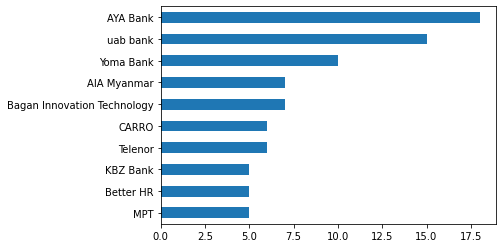

In [5]:
df['company'].value_counts().head(10).plot(kind="barh").invert_yaxis();

In [6]:
pattern = "freelance | self-employed"
df = df[~df['company'].str.contains(pattern, case=False)]

#### Top 10 Positions

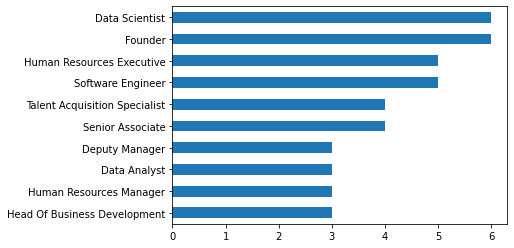

In [7]:
df['position'].value_counts().head(10).plot(kind="barh").invert_yaxis();

### Month connected on Histogram

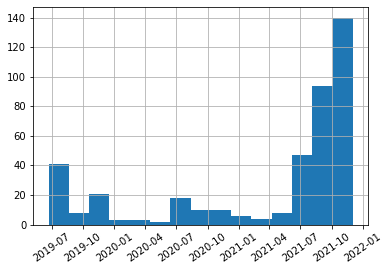

In [8]:
df['connected_on'].hist(xrot=35,bins=15);

#### Aggregate position and connection columns

In [9]:
df_company = df['company'].value_counts().reset_index()
df_company.columns = ['company','count']
df_company = df_company.sort_values(by="count", ascending=False)
df_company.head(10)

,company,count
0,AYA Bank,18
1,uab bank,15
2,Yoma Bank,10
3,AIA Myanmar,7
4,Bagan Innovation Technology,7
5,CARRO,6
6,Telenor,6
7,KBZ Bank,5
8,Better HR,5
9,MPT,5


In [10]:
df_position = df['position'].value_counts().reset_index()
df_position.columns = ['position','count']
df_position = df_position.sort_values(by="count", ascending=False)
df_position.head(10)

,position,count
0,Data Scientist,6
1,Founder,6
2,Human Resources Executive,5
3,Software Engineer,5
4,Talent Acquisition Specialist,4
5,Senior Associate,4
10,Product Manager,3
14,General Manager,3
12,Founder & CEO,3
11,Assistant General Manager,3


#### Creating the Network

##### Siimple Network

In [11]:
nt = net.Network(notebook=True)

g = nx.Graph()
g.add_node(0, label = "root") # intialize yourself as central node
g.add_node(1, label = "Company 1", size=10, title="info1")
g.add_node(2, label = "Company 2", size=40, title="info2")
g.add_node(3, label = "Company 3", size=60, title="info3")
g.add_edge(0,1)
g.add_edge(0,2)
g.add_edge(0,3)

nt.from_nx(g)
nt.show('nodes.html')
display(HTML('nodes.html'))

In [12]:
print(f"number of nodes: {g.number_of_nodes()}")
print(f"number of edges: {g.number_of_edges()}")

number of nodes: 4
number of edges: 3


##### Reduce size of nodes

In [13]:
print(df_company.shape)
df_company_reduced = df_company.loc[df_company['count']>=5]
print(df_company_reduced.shape)

(263, 2)
(10, 2)


In [14]:
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=5]
print(df_position_reduced.shape)

(347, 2)
(4, 2)


#### Creating network for connnections

In [16]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_company_reduced.iterrows():

  # store company name and count
  company = row['company']
  count = row['count']

  title = f"<b>{company}</b> – {count}"
  positions = set([x for x in df[company == df['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#3449eb')
  g.add_edge('root', company, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('company_graph.html')
display(HTML('company_graph.html'))